<a href="https://www.kaggle.com/code/sadiqballo/mental-health-prediction?scriptVersionId=210612431" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [71]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


In [72]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

# Use ggplot style for plots
plt.style.use('ggplot')

In [73]:
# import datasets
train_df = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')

# display train set
train_df

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,140695,Vidya,Female,18.0,Ahmedabad,Working Professional,NaN,NaN,5.0,NaN,NaN,4.0,5-6 hours,Unhealthy,Class 12,No,2.0,4.0,Yes,1
140696,140696,Lata,Female,41.0,Hyderabad,Working Professional,Content Writer,NaN,5.0,NaN,NaN,4.0,7-8 hours,Moderate,B.Tech,Yes,6.0,5.0,Yes,0
140697,140697,Aanchal,Female,24.0,Kolkata,Working Professional,Marketing Manager,NaN,3.0,NaN,NaN,1.0,More than 8 hours,Moderate,B.Com,No,4.0,4.0,No,0
140698,140698,Prachi,Female,49.0,Srinagar,Working Professional,Plumber,NaN,5.0,NaN,NaN,2.0,5-6 hours,Moderate,ME,Yes,10.0,1.0,No,0


In [74]:
# overview of the dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [75]:
# summary statistics
train_df.describe().round(2)

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.00,140700.00,27897.00,112782.00,27898.00,27897.00,112790.00,140700.00,140696.00,140700.00
mean,70349.50,40.39,3.14,3.00,7.66,2.94,2.97,6.25,2.99,0.18
std,40616.74,12.38,1.38,1.41,1.46,1.36,1.42,3.85,1.41,0.39
min,0.00,18.00,1.00,1.00,5.03,1.00,1.00,0.00,1.00,0.00
25%,35174.75,29.00,2.00,2.00,6.29,2.00,2.00,3.00,2.00,0.00
50%,70349.50,42.00,3.00,3.00,7.77,3.00,3.00,6.00,3.00,0.00
75%,105524.25,51.00,4.00,4.00,8.92,4.00,4.00,10.00,4.00,0.00
max,140699.00,60.00,5.00,5.00,10.00,5.00,5.00,12.00,5.00,1.00


In [76]:
# Count missing values in each column
train_df.isnull().sum()

id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

# **Exploratory Analysis**  

##  Univariate Analysis

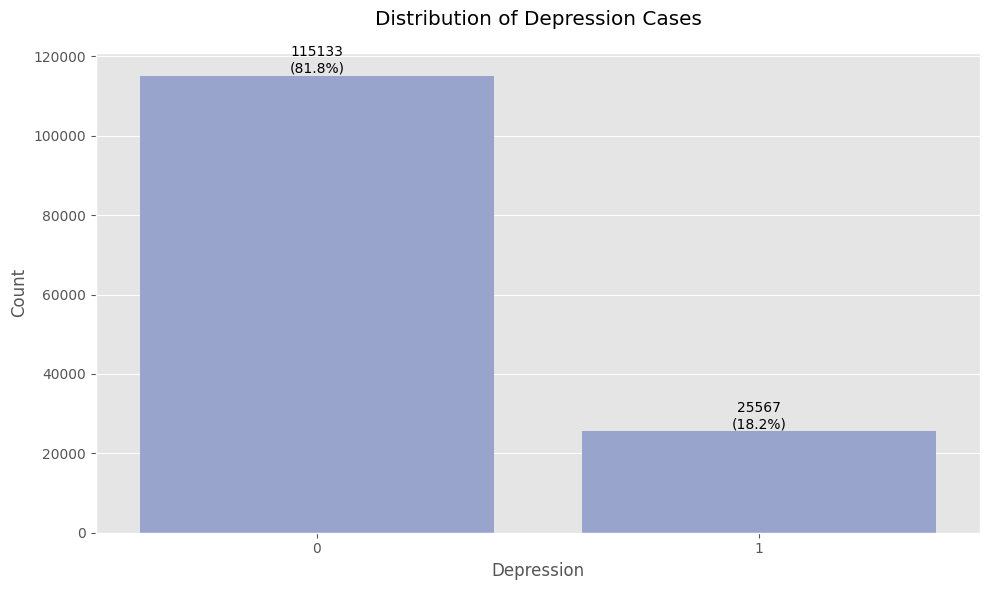

In [77]:
# Target Variable Distribution
plt.figure(figsize=(10, 6))

# Calculate percentages
total = len(train_df)
depression_counts = train_df['Depression'].value_counts()
depression_percentages = (depression_counts / total * 100).round(1)

ax = sns.countplot(data=train_df, x='Depression', color='#8F9FD4')

# Add value labels on top of each bar
for i, v in enumerate(depression_counts):
    percentage = depression_percentages[i]
    ax.text(i, v, f'{v}\n({percentage}%)', 
            ha='center', va='bottom')

# Customize the plot
plt.title('Distribution of Depression Cases', pad=20)
plt.xlabel('Depression')
plt.ylabel('Count')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

We have an unbalanced target. Most of the people (82%) in the dataset have no Depression!

In [78]:
# Create variables for the numerical and categorical variables
numerical_columns = train_df.select_dtypes(include=['float64']).columns
categorical_columns = train_df.select_dtypes(include=['object']).columns
print(numerical_columns)
print(categorical_columns)

Index(['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
       'Financial Stress'],
      dtype='object')
Index(['Name', 'Gender', 'City', 'Working Professional or Student',
       'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?',
       'Family History of Mental Illness'],
      dtype='object')


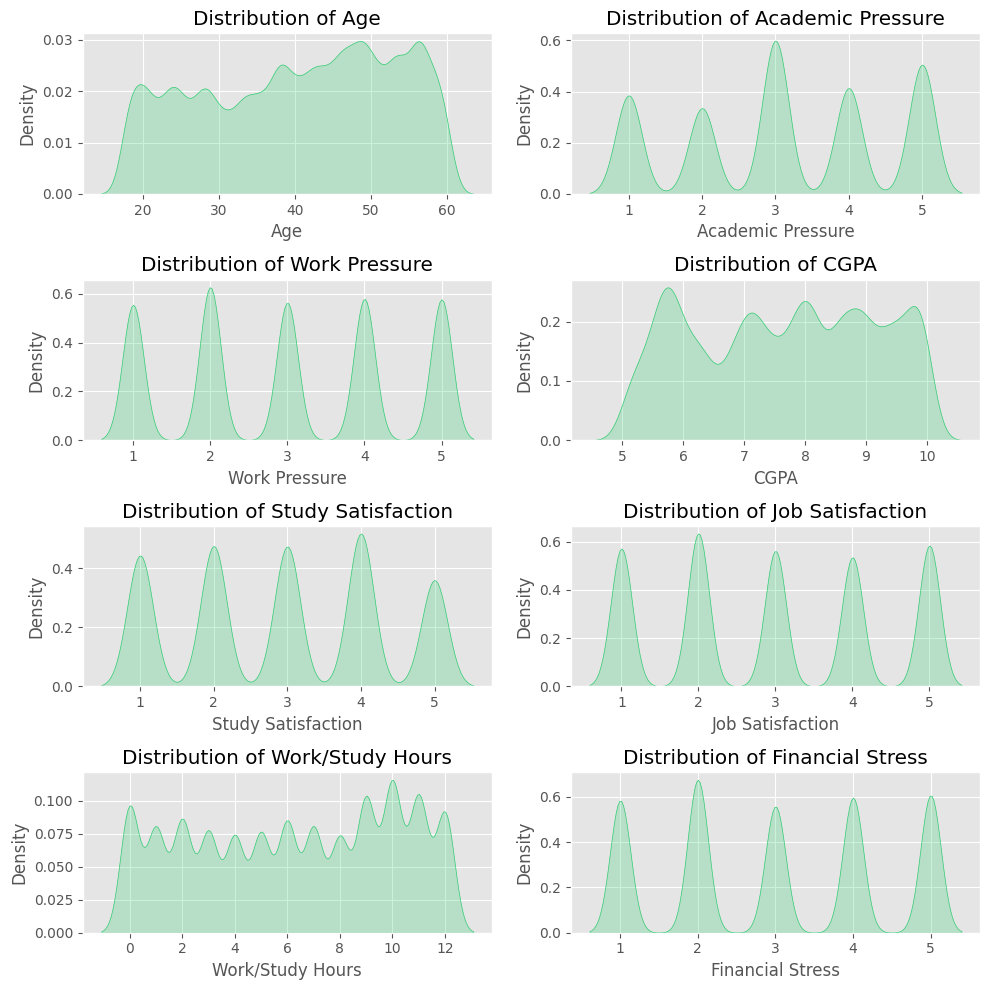

In [79]:
# Plot the distribution of the numerical columns
# Create figure
fig, axes = plt.subplots(4,2, figsize=(10,10))
axes = axes.flatten()

# Plot distributions
for i, col in enumerate(numerical_columns):
    sns.kdeplot(data=train_df[col], ax=axes[i], fill=True, color='#2ecc71')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Adjust layout and display
plt.tight_layout()
plt.show()

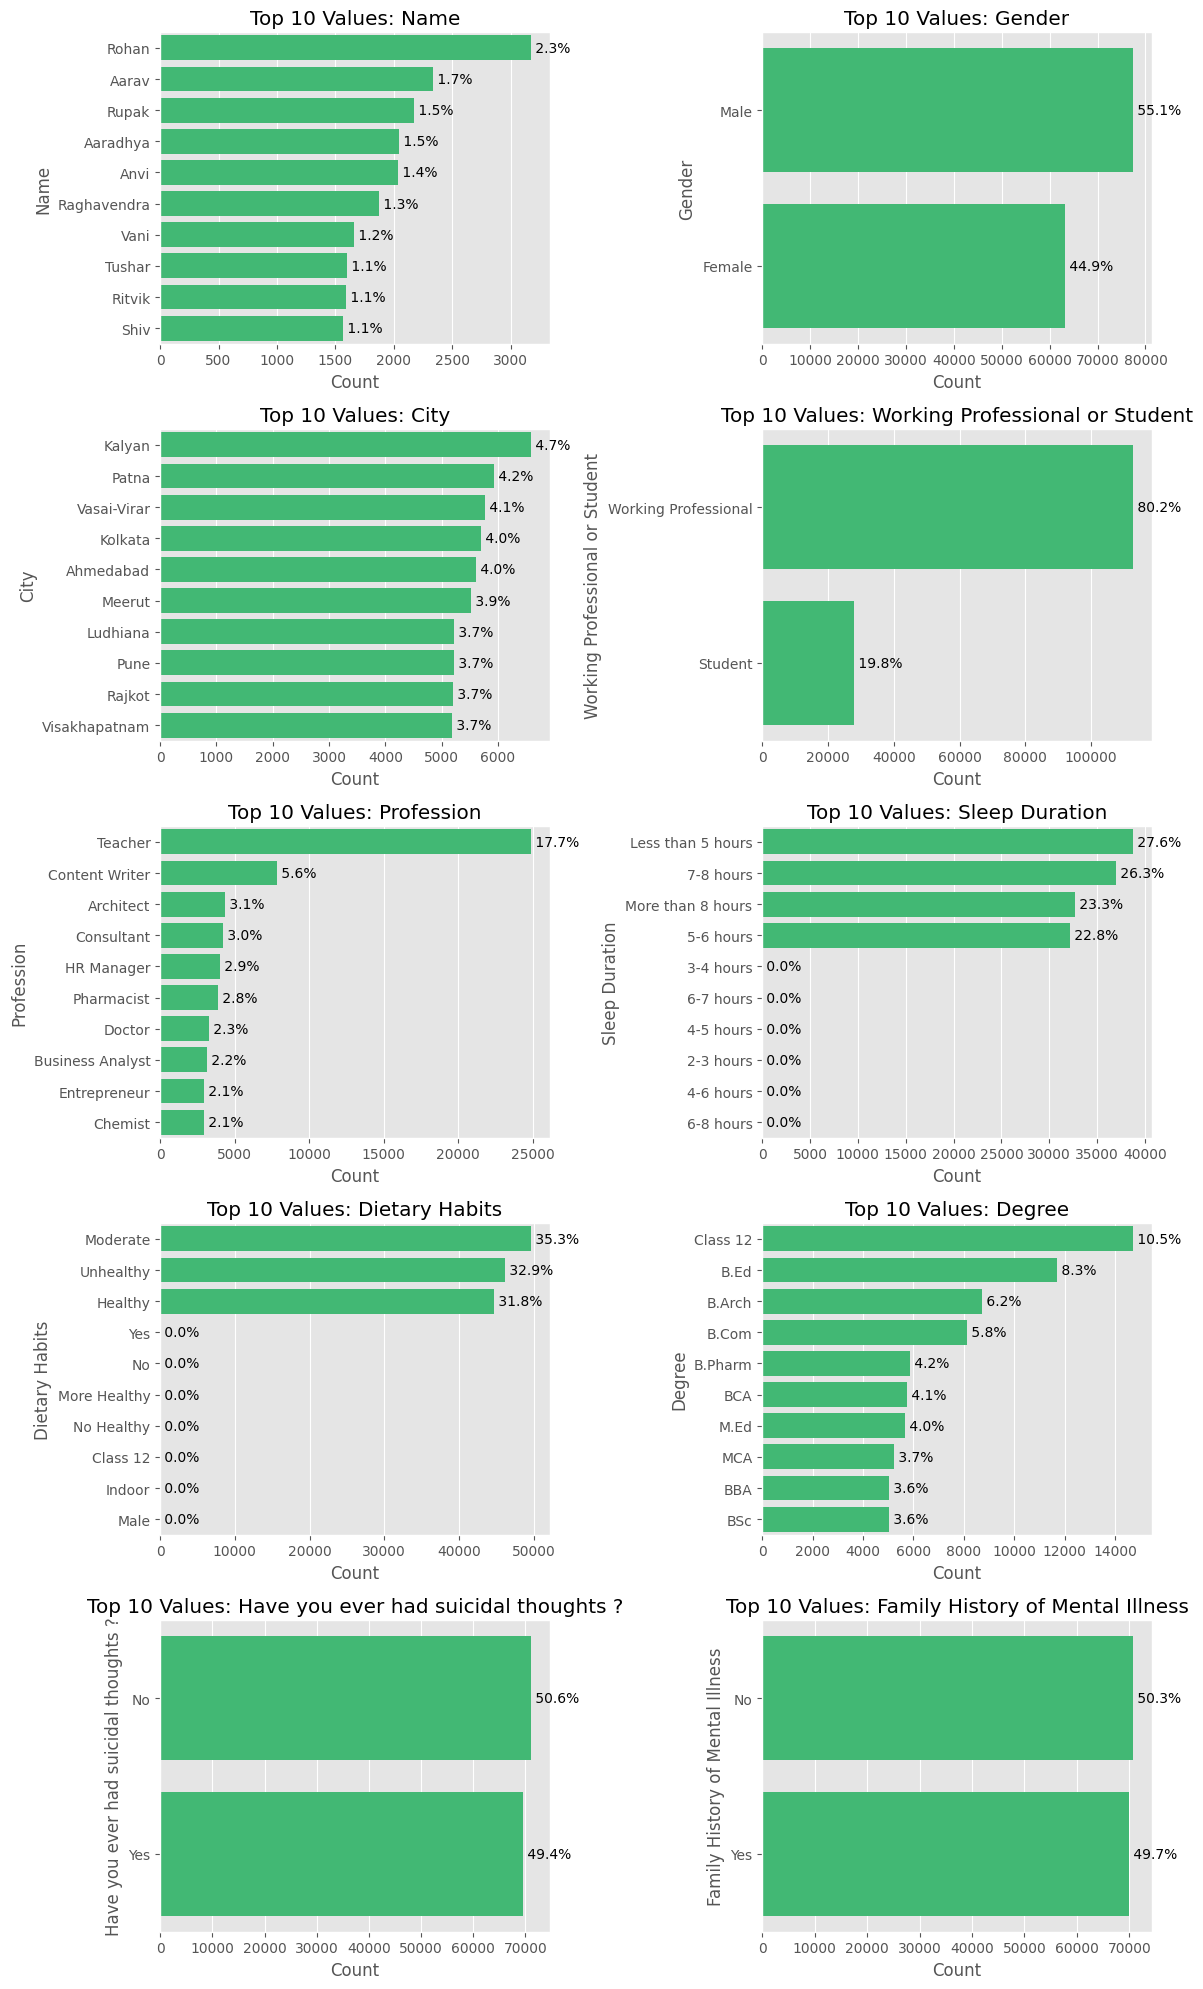

In [80]:
# Plot the distribution of the categorical columns
# Create figure
fig, axes = plt.subplots(5, 2, figsize=(12, 20))
axes = axes.flatten()

# Plot distributions
for i, col in enumerate(categorical_columns):
    # Get value counts and percentages
    value_counts = train_df[col].value_counts()
    top_10_values = value_counts.nlargest(10)
    top_10_percentages = (top_10_values / len(train_df) * 100).round(1)
    
    # Create a plot using only top 10 values
    bars = sns.barplot(x=top_10_values.values, 
                      y=top_10_values.index, 
                      ax=axes[i], color='#2ecc71')
    
    # Add percentage labels
    for j, v in enumerate(top_10_values.values):
        axes[i].text(v, j, f' {top_10_percentages.iloc[j]}%', 
                    va='center')
    
    axes[i].set_title(f'Top 10 Values: {col}')
    axes[i].set_ylabel(col)
    axes[i].set_xlabel('Count')

# Remove empty subplots if any
for i in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and display
plt.tight_layout()
plt.show()

## Multivariate Plot 

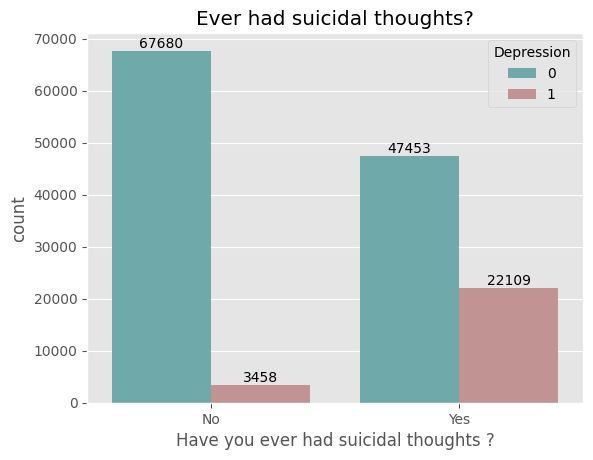

In [81]:
# Count of people with suicidal thoughts who have Depression

ax = sns.countplot(data=train_df, 
              x='Have you ever had suicidal thoughts ?', 
              hue='Depression', 
              palette=['#66b2b2', '#c98b8b'])

# Add count to bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.title('Ever had suicidal thoughts?')
plt.show()

**32%** of people (about 1 in 3) with suicidal thoughts are depressed compared to only **5%** of people without suicidal thought.

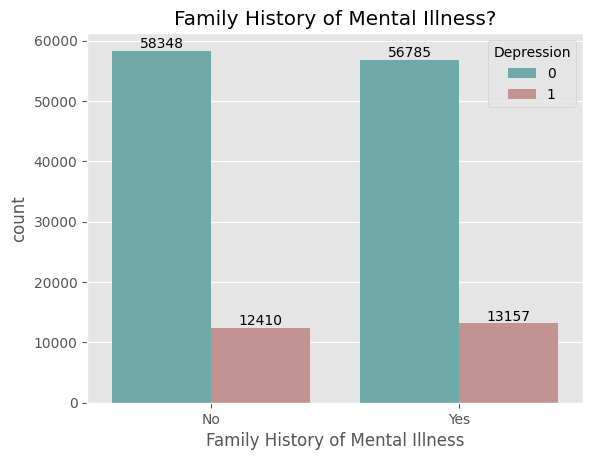

In [82]:
# Count of people with Family History of Mental Illness who have Depression

ax = sns.countplot(data=train_df, 
              x='Family History of Mental Illness', 
              hue='Depression',
              palette=['#66b2b2', '#c98b8b'])

# Add count to the plot
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.title('Family History of Mental Illness?')
plt.show()

There aren't much difference in case of depression when it comes to history of family mental illness. **17.5%** of people with no family mental illness have depression and **18.8%** of people with history of mental illness have depression.

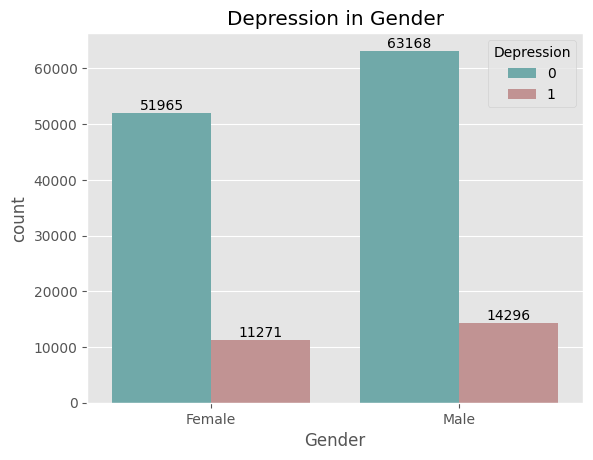

In [83]:
# Count of Depression in Gender

ax = sns.countplot(data=train_df, 
              x='Gender', 
              hue='Depression',
              palette=['#66b2b2', '#c98b8b'])

for container in ax.containers:
    ax.bar_label(container, fmt='%d')
    
plt.title('Depression in Gender')
plt.show()

Rate of depression is slightly higher in Males (18.5%) than Females (17.8%)

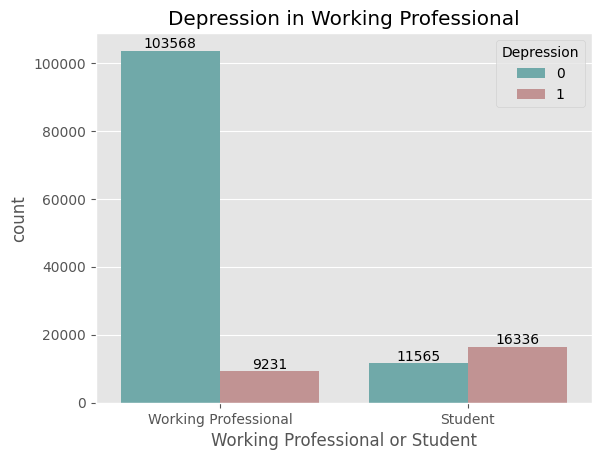

In [84]:
# Count of Depression in Working Professional

ax = sns.countplot(data=train_df, 
              x='Working Professional or Student', 
              hue='Depression',
              palette=['#66b2b2', '#c98b8b'])

for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.title('Depression in Working Professional')
plt.show()

More than half (58.5%) of the students in the dataset have depression compared to only (8.2%) of working professionals.

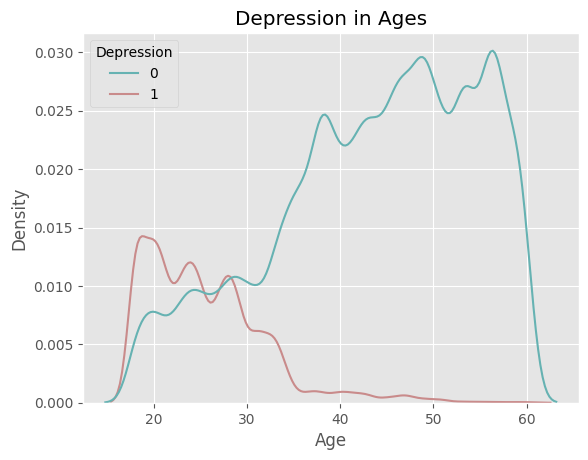

In [85]:
# Count of Depression in Ages

sns.kdeplot(data=train_df, 
              x='Age', 
              hue='Depression',
              palette=['#66b2b2', '#c98b8b'])
plt.title('Depression in Ages')
plt.show()

Depression is less common as people get older

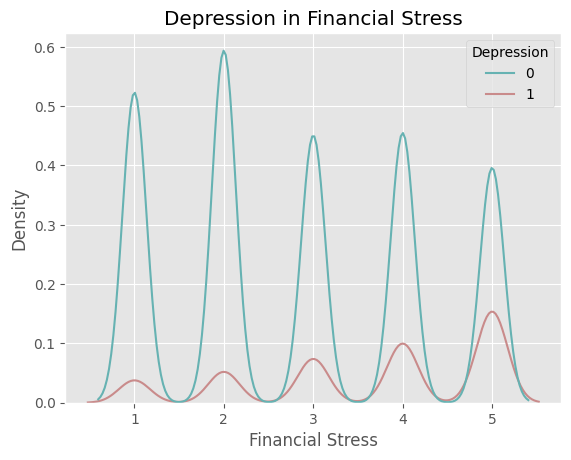

In [86]:

# Count of Depression in Financial Stress

sns.kdeplot(data=train_df, 
              x='Financial Stress', 
              hue='Depression',
              palette=['#66b2b2', '#c98b8b'])
plt.title('Depression in Financial Stress')
plt.show()

# Data Cleaning

In [87]:
# Check unique values in some the "Working Professional or Student" Column
print(train_df['Working Professional or Student'].unique())

# Check unique values in some the "Profession" Column
print(f"\n Number of unique values in the Profession column: {train_df['Profession'].nunique()} \n")
print(train_df['Profession'].unique())

['Working Professional' 'Student']

 Number of unique values in the Profession column: 64 

['Chef' 'Teacher' nan 'Business Analyst' 'Finanancial Analyst' 'Chemist'
 'Electrician' 'Software Engineer' 'Data Scientist' 'Plumber'
 'Marketing Manager' 'Accountant' 'Entrepreneur' 'HR Manager'
 'UX/UI Designer' 'Content Writer' 'Educational Consultant'
 'Civil Engineer' 'Manager' 'Pharmacist' 'Financial Analyst' 'Architect'
 'Mechanical Engineer' 'Customer Support' 'Consultant' 'Judge'
 'Researcher' 'Pilot' 'Graphic Designer' 'Travel Consultant'
 'Digital Marketer' 'Lawyer' 'Research Analyst' 'Sales Executive' 'Doctor'
 'Unemployed' 'Investment Banker' 'Family Consultant' 'B.Com' 'BE'
 'Student' 'Yogesh' 'Dev' 'MBA' 'LLM' 'BCA' 'Academic' 'Profession'
 'FamilyVirar' 'City Manager' 'BBA' 'Medical Doctor'
 'Working Professional' 'MBBS' 'Patna' 'Unveil' 'B.Ed' 'Nagpur' 'Moderate'
 'M.Ed' 'Analyst' 'Pranav' 'Visakhapatnam' 'PhD' 'Yuvraj']


_________
So many inconsistencies in the column that doesn't correspond to a known profession e.g Pranav, Moderate, B.Ed...

* The below code cell put a list of valid professions together, standardise some professions by fixing spelling error and making some assumptions.
* The missing values under profession column is filled with Student if the person is a student according to the  "Working Professional or Student" column.
* If the person is working professional has missing profession, I fill it with "Unknown"

In [88]:
# Cleaning the the Profession column

# List of valid professions
valid_professions = [
    'Chef', 'Teacher', 'Business Analyst', 'Financial Analyst', 'Chemist',
    'Electrician', 'Software Engineer', 'Data Scientist', 'Plumber',
    'Marketing Manager', 'Accountant', 'Entrepreneur', 'HR Manager',
    'UX/UI Designer', 'Content Writer', 'Educational Consultant',
    'Civil Engineer', 'Manager', 'Pharmacist', 'Architect',
    'Mechanical Engineer', 'Customer Support', 'Consultant', 'Judge',
    'Researcher', 'Pilot', 'Graphic Designer', 'Travel Consultant',
    'Digital Marketer', 'Lawyer', 'Research Analyst', 'Sales Executive',
    'Doctor', 'Investment Banker', 'Family Consultant', 'City Manager',
    'Medical Doctor', 'Analyst', 'Unemployed', 'Professor', 'Academia'
]

# Dictionary for standardizing profession names
profession_standardization = {
    'Finanancial Analyst': 'Financial Analyst',  # Fix spelling error
    'Medical Doctor': 'Doctor',                  # Standardize Doctor terms
    'Academic': 'Academia',                      # Standardize Academic to Academia
    'Profession': 'Professor',                   # Convert Profession to Professor
}

def clean_profession(row):
    # First, check if it's a student
    if row['Working Professional or Student'] == 'Student':
        return 'Student'

    profession = row['Profession']

    # If profession is NaN, return Unknown
    if pd.isna(profession):
        return 'Unknown'

    # Standardize profession names if they're in our standardization dictionary
    profession = profession_standardization.get(profession, profession)

    # If profession is not in valid list, return Unknown
    if profession not in valid_professions and profession != 'Student':
        return 'Unknown'

    return profession

# Apply the function to your DataFrame
train_df['Profession'] = train_df.apply(clean_profession, axis=1)


# Display value counts to see the distribution
print("\nProfession distribution:")
print(train_df['Profession'].value_counts())


Profession distribution:
Profession
Student                   27905
Teacher                   24900
Unknown                    8791
Content Writer             7812
Architect                  4362
Consultant                 4229
HR Manager                 4022
Pharmacist                 3891
Doctor                     3254
Business Analyst           3161
Chemist                    2967
Entrepreneur               2967
Financial Analyst          2903
Chef                       2860
Educational Consultant     2851
Data Scientist             2390
Researcher                 2328
Lawyer                     2211
Customer Support           2055
Marketing Manager          1976
Pilot                      1913
Travel Consultant          1860
Plumber                    1748
Sales Executive            1739
Manager                    1736
Judge                      1712
Electrician                1582
Software Engineer          1510
Civil Engineer             1469
UX/UI Designer             1451
Dig

________

The below cell follows the assumption that: Student should have academic pressure and Working professional should have work pressure
* if you're a working professional and you have missing academic pressure, It will be filled with 0, if you have missing work pressure, it will be filled with the mean of work pressure.
* if you're a student and you have missing work pressure, It will be filled with 0, if you have missing academic pressure, it will be filled with the mean of academic pressure.

In [89]:
# Cleaning Academic Pressure and Work Pressure column
"""
Assumption: Working professional should have no academic pressure, and students should have no work pressure
"""
def fill_pressure_columns(df):
    # Create a copy of the dataframe to avoid warnings
    df = df.copy()

    # Calculate mean of Academic Pressure for students
    student_academic_mean = df[df['Working Professional or Student'] == 'Student']['Academic Pressure'].mean()

    # Calculate mean of Work Pressure for working professionals
    work_prof_work_mean = df[df['Working Professional or Student'] == 'Working Professional']['Work Pressure'].mean()

    # Fill Academic Pressure
    df['Academic Pressure'] = df.apply(
        lambda row: 0 if row['Working Professional or Student'] == 'Working Professional'
        else student_academic_mean if pd.isna(row['Academic Pressure'])
        else row['Academic Pressure'],
        axis=1
    )

    # Fill Work Pressure
    df['Work Pressure'] = df.apply(
        lambda row: 0 if row['Working Professional or Student'] == 'Student'
        else work_prof_work_mean if pd.isna(row['Work Pressure'])
        else row['Work Pressure'],
        axis=1
    )

    return df

# Apply the function
train_df = fill_pressure_columns(train_df)

**The below cell calculates mean of the CGPA in two groups: working professional and student. the mean of these groups are used to fill their missing CGPA accordingly**

In [90]:
# Fill missing values in CGPA column

import pandas as pd
import numpy as np

def fill_cgpa_by_status(df):
    # Create a copy of the dataframe to avoid warnings
    df = df.copy()

    # Calculate mean CGPA for students and working professionals
    student_mean_cgpa = df[df['Working Professional or Student'] == 'Student']['CGPA'].mean()
    working_prof_mean_cgpa = df[df['Working Professional or Student'] == 'Working Professional']['CGPA'].mean()

    # Fill CGPA based on status
    df['CGPA'] = df.apply(
        lambda row: working_prof_mean_cgpa if (row['Working Professional or Student'] == 'Working Professional' and pd.isna(row['CGPA']))
        else student_mean_cgpa if (row['Working Professional or Student'] == 'Student' and pd.isna(row['CGPA']))
        else row['CGPA'],
        axis=1
    )

    return df
# Apply the function
train_df = fill_cgpa_by_status(train_df)

In [91]:
# Fill Missing Job and Study Statisfaction
"""
Assumption: If row is working professional, fill missing work statisfaction with mean else we fill with the minimum value which is 1.
If row is Student, fill missing study statisfaction with mean else we fill with the minimum value which is 1.
"""

def fill_satisfaction_columns(df):
    # Create a copy of the dataframe to avoid warnings
    df = df.copy()

    # Calculate means
    study_satisfaction_mean = df[df['Working Professional or Student'] == 'Student']['Study Satisfaction'].mean()
    job_satisfaction_mean = df[df['Working Professional or Student'] == 'Working Professional']['Job Satisfaction'].mean()

    # Minimum value for both columns is 1
    min_value = 1

    # Fill Study Satisfaction
    df['Study Satisfaction'] = df.apply(
        lambda row: study_satisfaction_mean if (row['Working Professional or Student'] == 'Student' and pd.isna(row['Study Satisfaction']))
        else min_value if pd.isna(row['Study Satisfaction'])
        else row['Study Satisfaction'],
        axis=1
    )

    # Fill Job Satisfaction
    df['Job Satisfaction'] = df.apply(
        lambda row: job_satisfaction_mean if (row['Working Professional or Student'] == 'Working Professional' and pd.isna(row['Job Satisfaction']))
        else min_value if pd.isna(row['Job Satisfaction'])
        else row['Job Satisfaction'],
        axis=1
    )

    return df
    
# Apply the function
train_df = fill_satisfaction_columns(train_df)

This code cleans and standardizes the **'Dietary Habits'** column in our dataset. It simplifies various responses into consistent categories: **'Healthy'**, **'Moderate'**, or **'Unhealthy'**. By handling inconsistencies and filling in missing or unclear entries with a default category, it ensures that the dietary habits data is uniform

In [92]:
# Clean Dietary Habits column

def clean_dietary_habits(df):
    # Create a copy of the dataframe
    df = df.copy()

    # Create mapping dictionary for standardization
    dietary_mapping = {
        'Moderate': 'Moderate',
        'Unhealthy': 'Unhealthy',
        'Healthy': 'Healthy',
        'More Healthy': 'Healthy',
        'No Healthy': 'Unhealthy',
        'Less Healthy': 'Unhealthy',
        'Less than Healthy': 'Unhealthy',
        'Yes': 'Moderate',  # Assuming 'Yes' without context should be Moderate
        'No': 'Unhealthy'  # Assuming 'No' without context should be Unhealthy
    }

    # Function to clean and standardize values
    def standardize_diet(value):
        if pd.isna(value):
            return 'Moderate'  # Fill missing values with most common category

        # Convert numeric values to string
        if isinstance(value, (int, float)):
            return 'Moderate'  # Assuming numeric values should be Moderate

        # Clean the string value
        value = str(value).strip()

        # Return mapped value if it exists, else return 'Moderate'
        return dietary_mapping.get(value, 'Moderate')

    # Apply the cleaning function
    df['Dietary Habits'] = df['Dietary Habits'].apply(standardize_diet)

    return df

# Apply the cleaning
train_df = clean_dietary_habits(train_df)

This code cleans and standardizes the 'Degree' column in our dataset. It maps various degree names and abbreviations to standardized degree titles for consistency. By accounting for different spellings, abbreviations, and possible errors in the data, it ensures that degrees like 'B.Tech', 'MBA', 'PhD', etc., are uniformly represented. Degrees that don't match the predefined categories or missing entries are labeled as 'Unknown'. 

In [93]:
# Clean the Degree column

def clean_degree(df):
    # Create a copy of the dataframe
    df = df.copy()

    # Define degree mappings for standardization
    degree_mapping = {
        # Bachelor's Degrees
        'B.Tech': 'B.Tech',
        'BE': 'B.Tech',
        'BTech': 'B.Tech',
        'E.Tech': 'B.Tech',

        'BBA': 'BBA',
        'B BA': 'BBA',
        'BB': 'BBA',
        'B B.Com': 'B.Com',

        'B.Com': 'B.Com',
        'BCom': 'B.Com',

        'BCA': 'BCA',
        'LCA': 'BCA',
        'HCA': 'BCA',
        'RCA': 'BCA',

        'BSc': 'B.Sc',
        'B.Sc': 'B.Sc',

        'B.Arch': 'B.Arch',
        'BArch': 'B.Arch',
        'B.B.Arch': 'B.Arch',
        'S.Arch': 'B.Arch',

        'B.Pharm': 'B.Pharm',
        'BPharm': 'B.Pharm',
        'H_Pharm': 'B.Pharm',
        'P.Pharm': 'B.Pharm',
        'S.Pharm': 'B.Pharm',
        'N.Pharm': 'B.Pharm',

        'BHM': 'BHM',
        'LHM': 'BHM',

        'B.Ed': 'B.Ed',
        'BEd': 'B.Ed',
        'L.Ed': 'B.Ed',
        'K.Ed': 'B.Ed',
        'LLEd': 'B.Ed',

        'BA': 'BA',

        'LLB': 'LLB',
        'LL B.Ed': 'LLB',
        'LLBA': 'LLB',
        'LLS': 'LLB',

        # Master's Degrees
        'M.Tech': 'M.Tech',
        'ME': 'M.Tech',
        'MTech': 'M.Tech',
        'M_Tech': 'M.Tech',

        'MBA': 'MBA',
        'M. Business Analyst': 'MBA',

        'MCA': 'MCA',

        'M.Com': 'M.Com',
        'MCom': 'M.Com',
        'LL.Com': 'M.Com',
        'LLCom': 'M.Com',
        'P.Com': 'M.Com',

        'MSc': 'M.Sc',
        'M.S': 'M.Sc',

        'M.Pharm': 'M.Pharm',
        'MPharm': 'M.Pharm',

        'M.Ed': 'M.Ed',
        'MEd': 'M.Ed',

        'M.Arch': 'M.Arch',

        'MA': 'MA',

        'MHM': 'MHM',

        'LLM': 'LLM',
        'LLTech': 'LLM',

        # Doctorate
        'PhD': 'PhD',

        # Medical
        'MBBS': 'MBBS',
        'MD': 'MD',

        # Others
        'Class 12': 'Class 12',
        'Class 11': 'Class 11'
    }

    def standardize_degree(value):
        if pd.isna(value):
            return 'Unknown'

        # Convert to string and clean
        value = str(value).strip()

        # Check if it's a number (including float)
        if value.replace('.', '').isdigit():
            return 'Unknown'

        # Return mapped value if it exists, else return 'Unknown'
        return degree_mapping.get(value, 'Unknown')

    # Apply the cleaning function
    df['Degree'] = df['Degree'].apply(standardize_degree)

    return df

# Apply the cleaning
train_df = clean_degree(train_df)

In [94]:
# Fill mising values under Financial Stress with the Mode

mode_value = train_df['Financial Stress'].mode()[0]
train_df['Financial Stress'] = train_df['Financial Stress'].fillna(mode_value)

In [95]:
# Overview of dataset after cleaning
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             140700 non-null  object 
 7   Academic Pressure                      140700 non-null  float64
 8   Work Pressure                          140700 non-null  float64
 9   CGPA                                   140700 non-null  float64
 10  Study Satisfaction                     140700 non-null  

In [96]:
# Statistics of dataset after cleaning
train_df.describe().round(2)

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.00,140700.00,140700.00,140700.00,140700.00,140700.00,140700.00,140700.00,140700.00,140700.00
mean,70349.50,40.39,0.62,2.40,7.89,1.39,2.58,6.25,2.99,0.18
std,40616.74,12.38,1.40,1.74,0.66,0.98,1.49,3.85,1.41,0.39
min,0.00,18.00,0.00,0.00,5.03,1.00,1.00,0.00,1.00,0.00
25%,35174.75,29.00,0.00,1.00,7.94,1.00,1.00,3.00,2.00,0.00
50%,70349.50,42.00,0.00,2.00,7.94,1.00,2.00,6.00,3.00,0.00
75%,105524.25,51.00,0.00,4.00,7.94,1.00,4.00,10.00,4.00,0.00
max,140699.00,60.00,5.00,5.00,10.00,5.00,5.00,12.00,5.00,1.00


# Data Preparation for ML

This code prepares the dataset for machine learning by performing these key steps:

* Removing Unnecessary Columns: Drops columns that aren't needed for modeling, like 'id'.
* Encoding Categorical Variables: Converts categories (like 'Gender', 'City', etc.) into numerical codes so that the machine learning algorithm can work with them.
* Scaling Numerical Features: Normalizes numerical data (like 'Age', 'CGPA', etc.) to ensure all features contribute equally to the model.
* Splitting the Data: Divides the data into training and testing sets to build and evaluate the machine learning model effectively.


In [97]:
def prepare_data_for_ml(df):
    # Create a copy of the dataframe
    df = df.copy()

    # 1. Remove unnecessary columns
    column_to_drop = ['id']
    df = df.drop(columns=column_to_drop)

    # 2. Handle categorical variables
    # Initialize label encoders for categorical columns
    label_encoders = {}
    categorical_columns = [
        'Name',
        'Gender', 
        'City', 
        'Working Professional or Student',
        'Profession',
        'Sleep Duration',
        'Dietary Habits',
        'Degree',
        'Have you ever had suicidal thoughts ?',
        'Family History of Mental Illness'
    ]

    # Apply label encoding
    for column in categorical_columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # 3. Scale numerical features
    numerical_columns = [
        'Age',
        'Academic Pressure',
        'Work Pressure',
        'CGPA',
        'Study Satisfaction',
        'Job Satisfaction',
        'Work/Study Hours',
        'Financial Stress'
    ]

    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    # 4. Split features and target
    X = df.drop('Depression', axis=1)
    y = df['Depression']

    # 5. Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'label_encoders': label_encoders,
        'scaler': scaler,
        'feature_names': X.columns.tolist()
    }

# Prepare the data
prepared_data = prepare_data_for_ml(train_df)

# Print information about the prepared data
print("Data preparation completed!")
print("\nFeatures used:", len(prepared_data['feature_names']))
print("Feature names:", prepared_data['feature_names'])
print("\nTraining set shape:", prepared_data['X_train'].shape)
print("Testing set shape:", prepared_data['X_test'].shape)
print("\nClass distribution in training set:")
print(prepared_data['y_train'].value_counts(normalize=True))
print("\nClass distribution in testing set:")
print(prepared_data['y_test'].value_counts(normalize=True))

Data preparation completed!

Features used: 18
Feature names: ['Name', 'Gender', 'Age', 'City', 'Working Professional or Student', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness']

Training set shape: (112560, 18)
Testing set shape: (28140, 18)

Class distribution in training set:
Depression
0    0.818284
1    0.181716
Name: proportion, dtype: float64

Class distribution in testing set:
Depression
0    0.818301
1    0.181699
Name: proportion, dtype: float64


# Correlation plot

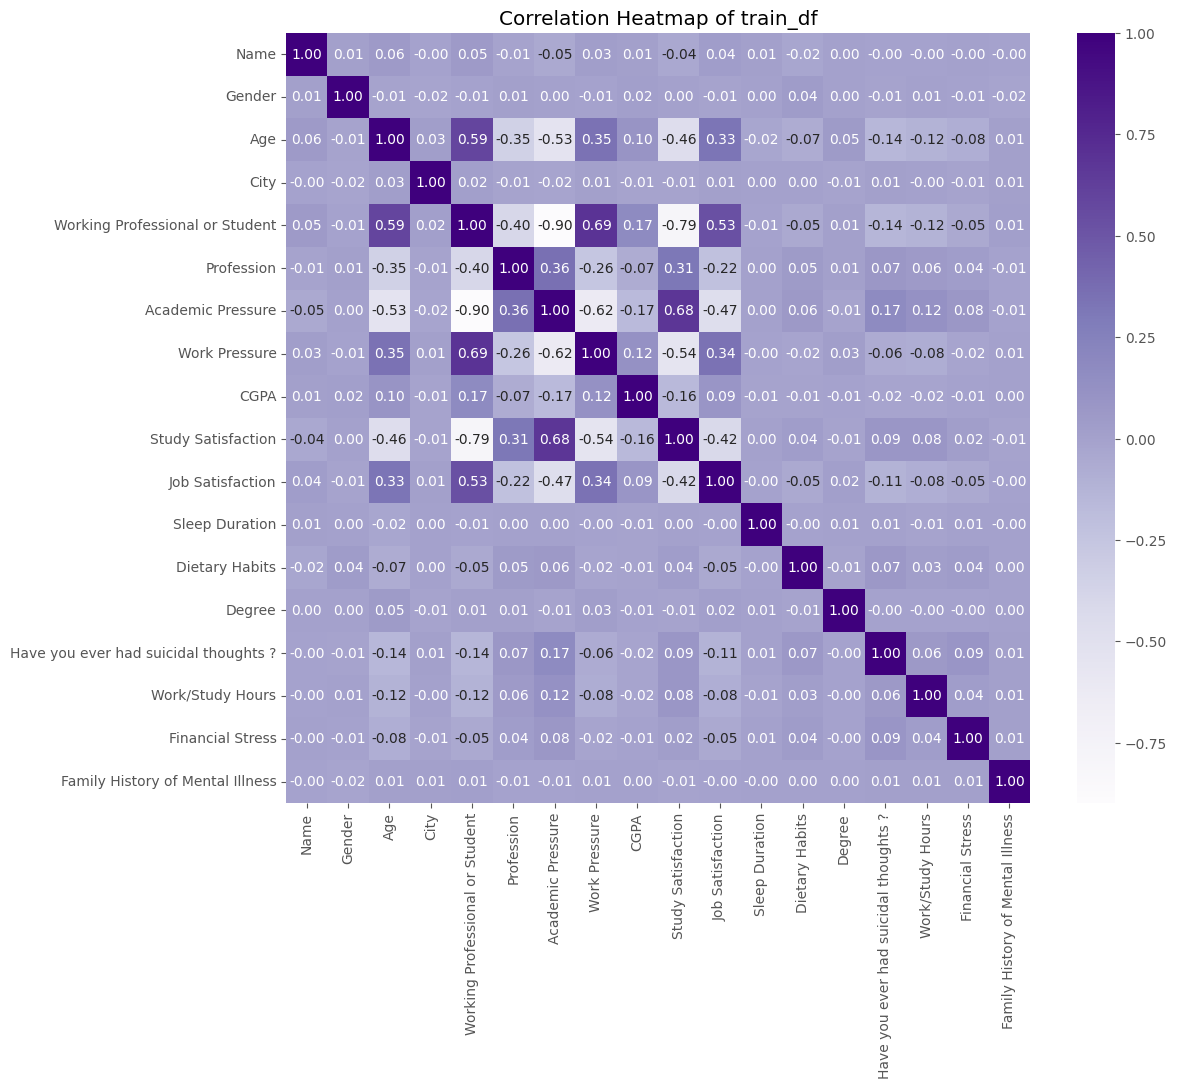

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(prepared_data['X_train'].corr(), annot=True, fmt=".2f", cmap='Purples')
plt.title('Correlation Heatmap of train_df')
plt.show()

# Machine Learning

## XGBoost

The below code trains an **XGBoost** machine learning model to predict depression based on the prepared dataset. It performs cross-validation to evaluate the model's accuracy, generates a classification report to assess performance metrics, and identifies the top features that most influence the predictions. Finally, it visualizes these important features using a bar chart.

Cross-validation results:
CV Accuracy scores: ['0.93874', '0.94057', '0.94030', '0.93555', '0.93790']
Mean CV Accuracy: 0.93861 (+/- 0.00364)

Classification Report:

0:
  precision: 0.95800
  recall: 0.96686
  f1-score: 0.96241
  support: 23027

1:
  precision: 0.84429
  recall: 0.80911
  f1-score: 0.82633
  support: 5113

accuracy: 0.93820

macro avg:
  precision: 0.90114
  recall: 0.88799
  f1-score: 0.89437
  support: 28140

weighted avg:
  precision: 0.93734
  recall: 0.93820
  f1-score: 0.93769
  support: 28140

Top 10 Most Important Features:
                                  feature importance
2                                     Age    0.38861
14  Have you ever had suicidal thoughts ?    0.26684
6                       Academic Pressure    0.08331
16                       Financial Stress    0.05583
10                       Job Satisfaction    0.04579
7                           Work Pressure    0.03588
12                         Dietary Habits    0.03038
15                  

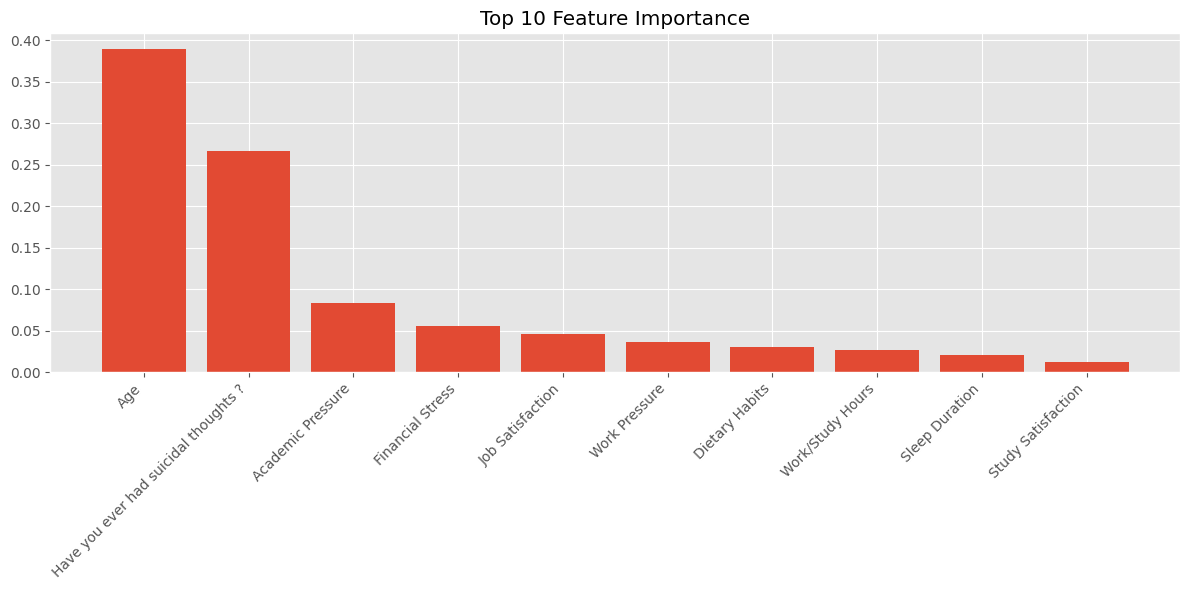

In [105]:
# Create and train XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    use_label_encoder=False,
    eval_metric='logloss'

)

# Perform k-fold cross-validation (k=5)
cv_scores = cross_val_score(xgb_model, 
                          prepared_data['X_train'], 
                          prepared_data['y_train'], 
                          cv=5, 
                          scoring='accuracy')

# Train the model on the full training set
xgb_model.fit(prepared_data['X_train'], 
              prepared_data['y_train'])

# Make predictions on test set
y_pred = xgb_model.predict(prepared_data['X_test'])

# Print results with 5 decimal places
print("Cross-validation results:")
print("CV Accuracy scores:", [f"{score:.5f}" for score in cv_scores])
print(f"Mean CV Accuracy: {cv_scores.mean():.5f} (+/- {cv_scores.std() * 2:.5f})")

# Custom function to format classification report with 5 decimal places
def custom_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    formatted_report = {}

    for key, value in report.items():
        if isinstance(value, dict):
            formatted_report[key] = {
                'precision': f"{value['precision']:.5f}",
                'recall': f"{value['recall']:.5f}",
                'f1-score': f"{value['f1-score']:.5f}",
                'support': value['support']
            }
        else:
            if key != 'support':
                formatted_report[key] = f"{value:.5f}"
            else:
                formatted_report[key] = value

    return formatted_report

print("\nClassification Report:")
report = custom_classification_report(prepared_data['y_test'], y_pred)
for label, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"\n{label}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value}")
    else:
        print(f"\n{label}: {metrics}")

# Get feature importance with 5 decimal places
feature_importance = pd.DataFrame({
    'feature': prepared_data['feature_names'],
    'importance': xgb_model.feature_importances_
})
feature_importance['importance'] = feature_importance['importance'].apply(lambda x: f"{x:.5f}")
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:10], 
        feature_importance['importance'][:10].astype(float))
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

## CatBoost

The below code trains a CatBoost machine learning model to predict depression based on the prepared dataset. It performs the following key steps:

* Training the Model:
Initializes the CatBoost classifier with predefined parameters.<br>
Trains the model on the training data while evaluating performance on the test set.<br>
* Making Predictions:
Uses the trained model to predict depression status on the test data.<br>
* Evaluating the Model:
Generates a detailed classification report to assess model performance.<br>
Creates and displays a confusion matrix to visualize the model's prediction accuracy.<br>
Calculates and plots the ROC curve to evaluate the model's ability to distinguish between classes.<br>
* Feature Importance:
Identifies the most influential features affecting the predictions.<br>
Displays a bar chart of the top 10 features contributing to the model.<br>
* Cross-Validation:
Performs 5-fold cross-validation to validate the model's stability and generalization capability.<br>
Prints cross-validation scores to assess consistency across different subsets of data.<br>
* Saving the Model:
Saves the trained CatBoost model to a file for future use or deployment.<br>
* Model Parameters:
Outputs the parameters of the trained model for reference and reproducibility.

Training CatBoost model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Making predictions...

Classification Report:
              precision    recall  f1-score   support

           0    0.95941   0.96682   0.96310     23027
           1    0.84519   0.81576   0.83021      5113

    accuracy                        0.93937     28140
   macro avg    0.90230   0.89129   0.89666     28140
weighted avg    0.93865   0.93937   0.93895     28140



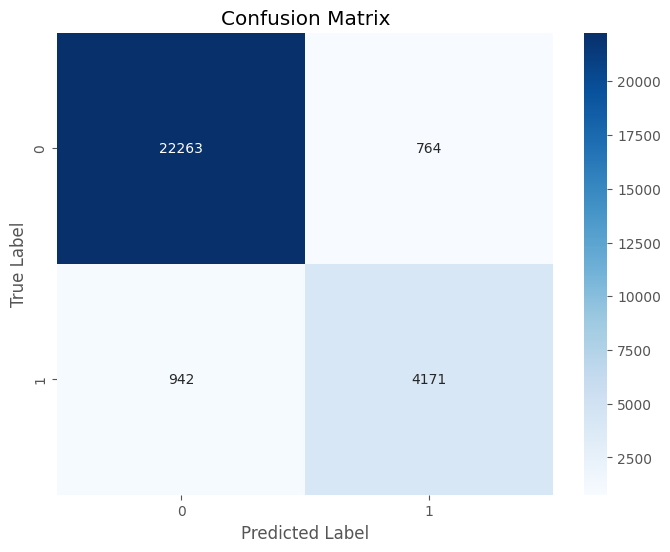

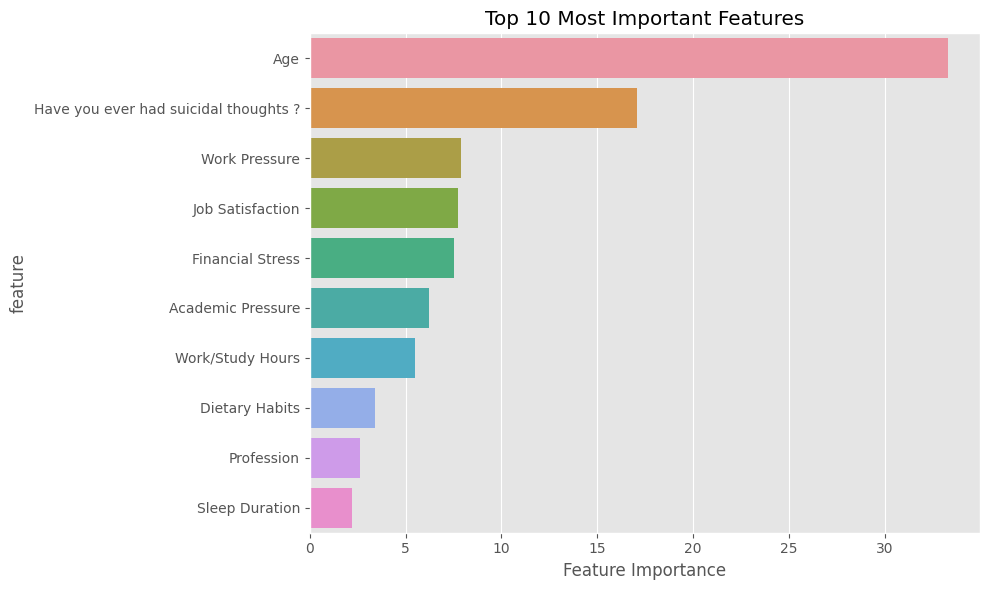


Performing 5-fold cross-validation...
Cross-validation scores: [0.9398543  0.94185323 0.94025409 0.93723348 0.93834399]
Mean CV score: 0.93951 (+/- 0.00319)


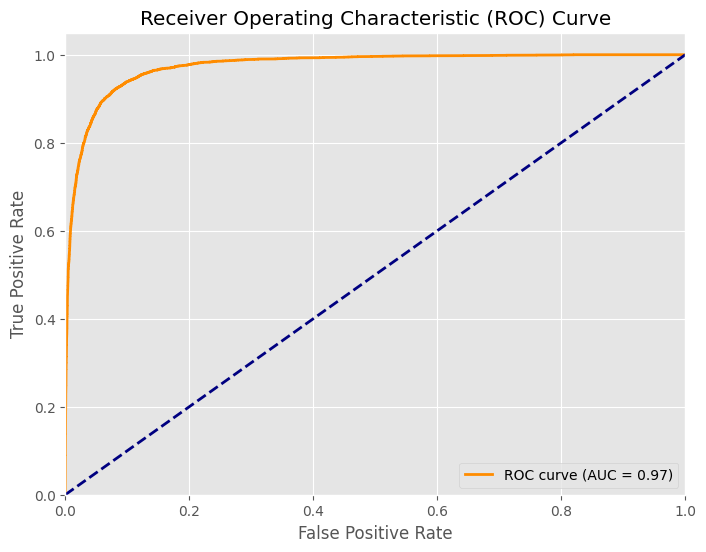


Model Parameters:
{'iterations': 500, 'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3, 'loss_function': 'Logloss', 'random_seed': 42, 'verbose': False, 'eval_metric': 'AUC', 'early_stopping_rounds': 50}


In [106]:
# Assuming we have X_train, X_test, y_train, y_test from prepared_data
X_train = prepared_data['X_train']
X_test = prepared_data['X_test']
y_train = prepared_data['y_train']
y_test = prepared_data['y_test']

# Initialize CatBoost model with good default parameters
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=False, 
    early_stopping_rounds=50
)

# Create evaluation dataset
eval_dataset = Pool(
    data=X_test,
    label=y_test
)

# Train the model
print("Training CatBoost model...")
model.fit(
    X_train, 
    y_train,
    eval_set=eval_dataset,
    plot=True  # This will show training progress
)

# Make predictions
print("\nMaking predictions...")
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=5))

# Create confusion matrix plot
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance plot
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Perform cross-validation
print("\nPerforming 5-fold cross-validation...")
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.5f} (+/- {cv_scores.std() * 2:.5f})")

# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Save the model
model.save_model('catboost_model.cbm')

# Print model parameters
print("\nModel Parameters:")
print(model.get_params())

# Clean Test Data

In [107]:
test_df.isnull().sum()

id                                           0
Name                                         0
Gender                                       0
Age                                          0
City                                         0
Working Professional or Student              0
Profession                               24632
Academic Pressure                        75033
Work Pressure                            18778
CGPA                                     75034
Study Satisfaction                       75033
Job Satisfaction                         18774
Sleep Duration                               0
Dietary Habits                               5
Degree                                       2
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             0
Family History of Mental Illness             0
dtype: int64

In [108]:
# Clean test data and apply same transformation

# Apply the same cleaning functions to test_df
test_df['Profession'] = test_df.apply(clean_profession, axis=1)
test_df = fill_pressure_columns(test_df)
test_df = fill_cgpa_by_status(test_df)
test_df = fill_satisfaction_columns(test_df)
test_df = clean_dietary_habits(test_df)
test_df = clean_degree(test_df)

In [109]:
def prepare_test_data(df, label_encoders, scaler, feature_names):
    # Create a copy of the dataframe
    df = df.copy()

    # Remove unnecessary columns
    column_to_drop = ['id']
    df = df.drop(columns=column_to_drop)

    # Handle categorical variables using the same label encoders
    categorical_columns = [
        'Name',
        'Gender', 
        'City', 
        'Working Professional or Student',
        'Profession',
        'Sleep Duration',
        'Dietary Habits',
        'Degree',
        'Have you ever had suicidal thoughts ?',
        'Family History of Mental Illness'
    ]

    for column in categorical_columns:
        if column in label_encoders:
            # Get the encoder for the column
            encoder = label_encoders[column]

            # Handle unseen categories by adding them to the encoder
            unseen_categories = set(df[column].unique()) - set(encoder.classes_)
            if unseen_categories:
                # Add unseen categories to the encoder
                encoder.classes_ = np.append(encoder.classes_, list(unseen_categories))

            # Transform the column
            df[column] = encoder.transform(df[column])

    # Scale numerical features using the same scaler
    numerical_columns = [
        'Age',
        'Academic Pressure',
        'Work Pressure',
        'CGPA',
        'Study Satisfaction',
        'Job Satisfaction',
        'Work/Study Hours',
        'Financial Stress'
    ]

    df[numerical_columns] = scaler.transform(df[numerical_columns])

    # Ensure the test data has the same feature columns as the training data
    df = df[feature_names]

    return df

In [110]:
# Apply the preparation to test_df
X_test_cleaned = prepare_test_data(
    test_df,
    label_encoders=prepared_data['label_encoders'],
    scaler=prepared_data['scaler'],
    feature_names=prepared_data['feature_names']
)

# Print the shape of the cleaned test data
print("Test data preparation completed!")
print("Test set shape:", X_test_cleaned.shape)

Test data preparation completed!
Test set shape: (93800, 18)


## Generate Predictions for Test Data

In [111]:
# Generate predictions for the new test data
print("\nGenerated predictions on new test data...")
new_y_pred = model.predict(X_test_cleaned)
new_y_pred_proba = model.predict_proba(X_test_cleaned)[:, 1]


Generated predictions on new test data...


In [112]:
# Load the sample submission file
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')

# Replace the 'Depression' column with your predictions
sample_submission['Depression'] = new_y_pred

# Save the updated submission file
sample_submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully!")

Submission file 'submission.csv' created successfully!
